In [11]:
import numpy as np
import pandas as pd
import xarray as xr

# Calculate the hourly average cell properties 

In [12]:
# Update Cell 3 with the data to calculate for different cases

In [13]:
%store -r filtered_ds stats_urban stats_upwind stats_downwind

In [14]:
# Read cell tracking data
time_res = filtered_ds.attrs['time_resolution_hour']
pixel_radius = filtered_ds.attrs['pixel_radius_km']

# Get cell initial location
cell_lon0 = filtered_ds['cell_meanlon'].isel(times=0)
ind = np.where(~np.isnan(cell_lon0))[0]

# Subset the tracks
filtered_ds = filtered_ds.isel(tracks=ind).load()
ntracks = filtered_ds.dims['tracks']

tracks = filtered_ds['tracks']
times = filtered_ds['times']

lifetime = filtered_ds['track_duration'] * time_res
start_time = filtered_ds['start_basetime']
end_time = filtered_ds['end_basetime']
end_merge_tracknumber = filtered_ds['end_merge_tracknumber']
start_split_tracknumber = filtered_ds['start_split_tracknumber']
cell_lon = filtered_ds['cell_meanlon']
cell_lat = filtered_ds['cell_meanlat']
cell_area = filtered_ds['cell_area']
maxrange_flag = filtered_ds['maxrange_flag']

maxdbz = filtered_ds['max_dbz']
eth20 = filtered_ds['maxETH_20dbz']

In [15]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=float)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [16]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]

In [17]:
# Get initiation and time
hour_bin = np.arange(0, 25, 1)

hist_starthour, bins = np.histogram(start_hour, bins=hour_bin, range=(0,24), density=False)
hist_starthour_in, bins = np.histogram(start_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

hist_endhour, bins = np.histogram(end_hour, bins=hour_bin, range=(0,24), density=False)
hist_endhour_in, bins = np.histogram(end_hour.isel(tracks=nonmerge_in), bins=hour_bin, range=(0,24), density=False)

# Convert to local time (UTC-5)
hist_starthour_LT = np.roll(hist_starthour, -5)
hist_starthour_in_LT = np.roll(hist_starthour_in, -5)

hist_endhour_LT = np.roll(hist_endhour, -5)
hist_endhour_in_LT = np.roll(hist_endhour_in, -5)

In [18]:
# Bin max cell diameter data by initiation hour for box plot
cell_area_mean_hourbin_circle = []
cell_diam_mean_hourbin_circle = []
cell_eth20_mean_hourbin_circle = []
cell_maxdbz_mean_hourbin_circle = []
for ihour in range(24):
    cell_area_mean_hourbin_circle.append((cell_area.where(start_hour == ihour, drop=True)).values)
    # cell_diam_mean_hourbin_circle.append(cell_diam.where(start_hour_circle == ihour, drop=True).values)
    cell_eth20_mean_hourbin_circle.append(eth20.where((start_hour == ihour) & (~np.isnan(eth20)), drop=True).values)
    cell_maxdbz_mean_hourbin_circle.append(maxdbz.where((start_hour == ihour) & (~np.isnan(maxdbz)), drop=True).values)
    

# Convert to local time (UTC-3) 
# cell_diam_max_hourbin_LT = np.roll(cell_diam_max_hourbin, -3)
# To avoid numpy warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated
# Convert the ragged list to a numpy object array
cell_diam_mean_hourbin_circle = np.array(cell_diam_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_diam_mean_hourbin_LT_circle = np.roll(cell_diam_mean_hourbin_circle, -5)
cell_area_mean_hourbin_circle = np.array(cell_area_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_area_mean_hourbin_LT_circle = np.roll(cell_area_mean_hourbin_circle, -5)
cell_eth20_mean_hourbin_circle = np.array(cell_eth20_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_eth20_mean_hourbin_LT_circle = np.roll(cell_eth20_mean_hourbin_circle, -5)
cell_maxdbz_mean_hourbin_circle = np.array(cell_maxdbz_mean_hourbin_circle, dtype=object, copy=False, subok=True)
cell_maxdbz_mean_hourbin_LT_circle = np.roll(cell_maxdbz_mean_hourbin_circle, -5)

In [19]:
area_means = [np.nanmean(cell_area_mean_hourbin_LT_circle[hour]) for hour in range(24)]
eth20_means = [np.nanmean(cell_eth20_mean_hourbin_LT_circle[hour]) for hour in range(24)]
maxdbz_means = [np.nanmean(cell_maxdbz_mean_hourbin_LT_circle[hour]) for hour in range(24)]

# Create a DataFrame
df = pd.DataFrame({
    'Hour (LT)': range(24),
    'Cell area (mean)': area_means,
    '20-dBZ echo top height (mean)': eth20_means,
    'Reflectivity (mean)': maxdbz_means
})

df

,Hour (LT),Cell area (mean),20-dBZ echo top height (mean),Reflectivity (mean)
0,0,34.509438,5.109151,36.939102
1,1,37.284081,5.189774,36.715107
2,2,41.027103,5.658607,37.200130
3,3,36.059235,5.673636,36.613277
4,4,40.452923,5.780384,37.467876
5,5,43.608723,6.003098,38.824562
6,6,55.199791,6.491551,40.501049
7,7,50.634220,6.508707,40.009232
8,8,37.824726,5.902315,37.892056
9,9,36.153461,5.904912,37.655811


# Calculate the hourly sounding metrics

In [20]:
path = 'C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/sounding/soundings/*.nc'
data = xr.open_mfdataset(path, combine='by_coords')
data

<xarray.Dataset>
Dimensions:            (time: 132480, height: 332)
Coordinates:
  * time               (time) datetime64[ns] 2022-06-01T00:00:30 ... 2022-08-...
  * height             (height) float32 0.008 0.028 0.048 ... 39.51 40.01 40.51
Data variables: (12/39)
    base_time          (time) datetime64[ns] 2022-06-01 ... 2022-08-31
    time_offset        (time) datetime64[ns] dask.array<chunksize=(1440,), meta=np.ndarray>
    precip             (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_precip          (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    temp               (time, height) float32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    qc_temp            (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    ...                 ...
    qc_rh_scaled       (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    aqc_rh_scaled      (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    vapor_source       (time, height) int32 dask.array<chunksize=(1440, 332), meta=np.ndarray>
    lat                (time) float32 29.67 29.67 29.67 ... 29.67 29.67 29.67
    lon                (time) float32 -95.06 -95.06 -95.06 ... -95.06 -95.06
    alt                (time) float32 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0
Attributes: (12/13)
    command_line:          idl -R -n interpolatedsonde -s hou -f M1 -b 202206...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     hougriddedsondeM1.c0 : 3.2 : 20220530.000030-20220...
    site_id:               hou
    ...                    ...
    facility_id:           M1
    data_level:            c1
    location_description:  Tracking Aerosol Convection Interactions Experimen...
    datastream:            houinterpolatedsondeM1.c1
    doi:                   10.5439/1095316
    history:               created by user dsmgr on machine zinc at 2022-06-0...

In [21]:
# Extract the variables needed for the sounding
p = (data['bar_pres'][:, :] * 10.0).groupby('time.hour').mean()
rh = (data['rh'][:, :]).groupby('time.hour').mean()
T = data['temp'][:, :].groupby('time.hour').mean() 
Td = data['dp'][:, :].groupby('time.hour').mean()
wdir = data['wdir'][:, :].groupby('time.hour').mean()
wspd = (data['wspd'][:, :]).groupby('time.hour').mean()
height = (data['bar_pres']['height'].values * 1000.0)
precip = data['precip'][:].groupby('time.hour').mean()

In [22]:
# Loop over all timeframes and save the tables with the appropriate names
for i in range(24):
    # Extract the variables for this timeframe
    p_i = p[i, :]
    rh_i = rh[i, :]
    T_i = T[i, :]
    Td_i = Td[i, :]
    wdir_i = wdir[i, :]
    wspd_i = wspd[i, :]
    
    # Combine the data into a table
    data_table_i = np.vstack((height, p_i, T_i, Td_i, rh_i, wdir_i, wspd_i)).T
    
    # Remove rows with NaN values
    mask_i = np.isnan(data_table_i).any(axis=1)
    data_table_i = data_table_i[~mask_i]
    
    # Save the modified data table as a txt file with the appropriate name
    #time_str = data['time'][i].strftime('%H%M%S')
    filename = 'C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/sounding/Tables/hourly_24/data-' + str(i) + '.txt'
    headers = ['HGHT', 'PRES', 'TEMP', 'DWPT', 'RH', 'DIR', 'SPD']
    np.savetxt(filename, data_table_i, header='\t'.join(headers), fmt='%0.2f', delimiter='\t')

In [23]:

def find_nearest_pressure_wind_speed(df, target_pressure):
    # Calculate the absolute difference from the target pressure
    df['pressure_diff'] = abs(df['pressure'] - target_pressure)

    # Find the entry with the smallest difference to the target pressure
    nearest_pressure_entry = df.loc[df['pressure_diff'].idxmin()]

    return nearest_pressure_entry['speed']

In [24]:
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units

###########################################
# Effective Shear Algorithm for use in Supercell Composite Calculation


def effective_layer(p, t, td, h, height_layer=False):
    from metpy.calc import cape_cin, parcel_profile
    from metpy.units import units

    pbot = None

    for i in range(p.shape[0]):
        prof = parcel_profile(p[i:], t[i], td[i])
        sbcape, sbcin = cape_cin(p[i:], t[i:], td[i:], prof)
        if sbcape >= 100 * units('J/kg') and sbcin > -250 * units('J/kg'):
            pbot = p[i]
            hbot = h[i]
            bot_idx = i
            break
    if not pbot:
        return None, None

    for i in range(bot_idx + 1, p.shape[0]):
        prof = parcel_profile(p[i:], t[i], td[i])
        sbcape, sbcin = cape_cin(p[i:], t[i:], td[i:], prof)
        if sbcape < 100 * units('J/kg') or sbcin < -250 * units('J/kg'):
            ptop = p[i]
            htop = h[i]
            break

    if height_layer:
        return hbot, htop
    else:
        return pbot, ptop


###########################################
import pandas as pd
import os

# Loop over all the files from data-0 to data-1439
for i in range(24):
    # Construct the filename for the current file
    filename = f'data-{i}.txt'
    filepath = os.path.join('C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/sounding/Tables/hourly_24/', filename)

    # Read the text file into a pandas DataFrame
    col_names = ['height', 'pressure', 'temperature', 'dewpoint', 'rh', 'direction', 'speed']
    df = pd.read_csv(filepath, delim_whitespace=True, skiprows=2,  names=col_names)


    ###########################################
    # Isolate needed variables from our data file and attach units
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    wdir = df['direction'].values * units.degree
    sped = df['speed'].values * units.knot
    height = df['height'].values * units.meter

    # Compute wind speeds
    wind_surface = find_nearest_pressure_wind_speed(df, 1000)
    wind_900 = find_nearest_pressure_wind_speed(df, 900)
    wind_700 = find_nearest_pressure_wind_speed(df, 700)

    ###########################################
    # Compute the wind components
    u, v = mpcalc.wind_components(sped, wdir)

    ###########################################
    # Compute common sounding index parameters
    ctotals = mpcalc.cross_totals(p, T, Td)
    kindex = mpcalc.k_index(p, T, Td)
    showalter = mpcalc.showalter_index(p, T, Td)
    total_totals = mpcalc.total_totals_index(p, T, Td)
    vert_totals = mpcalc.vertical_totals(p, T)

    ###########################################
    # Compture the parcel profile for a surface-based parcel
    prof = mpcalc.parcel_profile(p, T[0], Td[0])

    ###########################################
    # Compute the corresponding LI, CAPE, CIN values for a surface parcel
    lift_index = mpcalc.lifted_index(p, T, prof)
    cape, cin = mpcalc.cape_cin(p, T, Td, prof)

    ###########################################
    # Determine the LCL, LFC, and EL for our surface parcel
    lclp, lclt = mpcalc.lcl(p[0], T[0], Td[0])
    lfcp, _ = mpcalc.lfc(p, T, Td)
    el_pressure, el_t = mpcalc.el(p, T, Td, prof)

    # Calculate the Sweat index
    sweat = mpcalc.sweat_index(p, T, Td, sped, wdir)

    # Compute convective condensation level
    ccl_p, ccl_t, ccl_dewp = mpcalc.ccl(p, T, Td)

    ###########################################
    # Compute the characteristics of a mean layer parcel (50-hPa depth)
    ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
    ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof, depth=50 * units.hPa)

    ###########################################
    # Compute the characteristics of the most unstable parcel (50-hPa depth)
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

    ###########################################
    # Compute the Bunkers Storm Motion vector and use to calculate the critical angle
    (u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, height)
    critical_angle = mpcalc.critical_angle(p, u, v, height, u_storm, v_storm)

    ###########################################
    # Work on the calculations needed to compute the significant tornado parameter

    # Estimate height of LCL in meters from hydrostatic thickness
    new_p = np.append(p[p > lclp], lclp)
    new_t = np.append(T[p > lclp], lclt)
    lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

    # Compute Surface-based CAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
    
    # Compute SRH
    *_, total_helicity1 = mpcalc.storm_relative_helicity(height, u, v, depth=1 * units.km,
                                                        storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity3 = mpcalc.storm_relative_helicity(height, u, v, depth=3 * units.km,
                                                        storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity6 = mpcalc.storm_relative_helicity(height, u, v, depth=6 * units.km,
                                                        storm_u=u_storm, storm_v=v_storm)

    # Copmute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=height, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=height, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=height, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

    # Use all computed pieces to calculate the Significant Tornado parameter
    sig_tor1 = mpcalc.significant_tornado(sbcape, lcl_height,
                                    total_helicity1, bshear1).to_base_units()
    sig_tor3 = mpcalc.significant_tornado(sbcape, lcl_height,
                                        total_helicity3, bshear1).to_base_units()
    sig_tor6 = mpcalc.significant_tornado(sbcape, lcl_height,
                                        total_helicity6, bshear3).to_base_units()

    ###########################################
    # Compute the supercell composite parameter, if possible

    # Determine the top and bottom of the effective layer using our own function
    hbot, htop = effective_layer(p, T, Td, height, height_layer=True)

    # Perform the calculation of supercell composite if an effective layer exists
    if hbot:
        esrh = mpcalc.storm_relative_helicity(height, u, v, depth=htop - hbot, bottom=hbot)
        eubshr, evbshr = mpcalc.bulk_shear(p, u, v, height=height, depth=htop - hbot, bottom=hbot)
        ebshear = mpcalc.wind_speed(eubshr, evbshr)

        super_comp = mpcalc.supercell_composite(mucape, esrh[0], ebshear)
    else:
        super_comp = np.nan

    
    # Create a dictionary of parameter names and values
    params = {
        'CAPE': [cape.magnitude, str(cape.units)],
        'Surface-based CAPE': [sbcape.magnitude, str(sbcape.units)],
        'CIN': [cin.magnitude, str(cin.units)],
        'Surface-based CIN': [sbcin.magnitude, str(sbcin.units)],
        'CCL Temperature': [ccl_t.magnitude, str(ccl_t.units)],
        'CCL Dewpoint': [ccl_dewp.magnitude, str(ccl_dewp.units)],
        'CCL Pressure': [ccl_p.magnitude, str(ccl_p.units)],
        'LCL Pressure': [lclp.magnitude, str(lclp.units)],
        'LFC Pressure': [lfcp.magnitude, str(lfcp.units)],
        'EL Pressure': [el_pressure.magnitude, str(el_pressure.units)],
        'EL Temperature': [el_t.magnitude, str(el_t.units)],
        'Lifted Index': [lift_index.magnitude, str(lift_index.units)],
        'K-Index': [kindex.magnitude, str(kindex.units)],
        'Showalter Index': [showalter.magnitude, str(showalter.units)],
        'SWEAT Index': [sweat.magnitude, str(sweat.units)],
        'Cross Totals': [ctotals.magnitude, str(ctotals.units)],
        'Total Totals': [total_totals.magnitude, str(total_totals.units)],
        'Vertical Totals': [vert_totals.magnitude, str(vert_totals.units)],
        'Mixed Layer - Lowest 50-hPa Temp': [ml_t.magnitude, str(ml_t.units)],
        'Mixed Layer - Lowest 50-hPa Dewp': [ml_td.magnitude, str(ml_td.units)],
        'Mixed Layer - Lowest 50-hPa CAPE': [mlcape.magnitude, str(mlcape.units)],
        'Mixed Layer - Lowest 50-hPa CIN': [mlcin.magnitude, str(mlcin.units)],
        'Most Unstable - Lowest 50-hPa Temp': [mu_t.magnitude, str(mu_t.units)],
        'Most Unstable - Lowest 50-hPa Dewp': [mu_td.magnitude, str(mu_td.units)],
        'Most Unstable - Lowest 50-hPa Pressure': [mu_p.magnitude, str(mu_p.units)],
        'Most Unstable - Lowest 50-hPa CAPE': [mucape.magnitude, str(mucape.units)],
        'Most Unstable - Lowest 50-hPa CIN': [mucin.magnitude, str(mucin.units)],
        'Bunkers Storm Motion Vector - u_storm': [u_storm.magnitude, str(u_storm.units)],
        'Bunkers Storm Motion Vector - v_storm': [v_storm.magnitude, str(v_storm.units)],
        'Critical Angle': [critical_angle.magnitude, str(critical_angle.units)],
        '0-1km Storm Relative Helicity': [total_helicity1.magnitude, str(total_helicity1.units)],
        '0-3km Storm Relative Helicity': [total_helicity3.magnitude, str(total_helicity1.units)],
        '0-6km Storm Relative Helicity': [total_helicity6.magnitude, str(total_helicity1.units)],
        '0-1km Bulk Shear': [bshear1.magnitude, str(bshear1.units)],
        '0-3km Bulk Shear': [bshear3.magnitude, str(bshear3.units)],
        '0-6km Bulk Shear': [bshear6.magnitude, str(bshear6.units)],
        'Surface Wind Speed': [wind_surface,],
        'Wind Speed at 900 hPa': [wind_900,],
        'Wind Speed at 700 hPa': [wind_700,],
    }
    
    # Create a new row with different values
    new_row = '\t'.join([str(value[0]) for value in params.values()])
    # Append the new row to the rows list
    # rows.append(new_row)

    # Write the header row and all the data rows to a file
    with open(f'C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/sounding/metrics/Individual_metrics/metrics_{i}.txt', 'w') as f:
        # Write the header row
        f.write('\t'.join(params.keys()) + '\n')

        # Write the data rows
        f.write(new_row + '\n')




In [25]:
for i in range(24):
    file_path = f'C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/sounding/metrics/Individual_metrics/metrics_{i}.txt'
    
    with open(file_path, 'r') as file:
        data = file.read()
    
    with open(file_path, 'w') as file:
        file.write(data.replace('[', '').replace(']', ''))

In [26]:
# Initialize an empty DataFrame to store the metrics with "Hour (LT)"
metrics_combined = pd.DataFrame()

# Load each metrics file, add the "Hour (LT)" column, and extract headers
for hour in range(24):
    file_path = f'C:/Users/omitu/Documents/GitHub/Urbanization-and-Climate-Change/Second_part/data/sounding/metrics/Individual_metrics/metrics_{hour}.txt'
    try:
        # Load the metrics data, using the first row as header
        metrics_df = pd.read_csv(file_path, header=0,  sep='\t')
        # Add "Hour (LT)" column with the hour number
        metrics_df['Hour (LT)'] = hour
        # Append this to the combined DataFrame
        metrics_combined = pd.concat([metrics_combined, metrics_df], ignore_index=True)
    except FileNotFoundError:
        print(f"File for hour {hour} not found.")


In [27]:
metrics_combined

,CAPE,Surface-based CAPE,CIN,Surface-based CIN,CCL Temperature,CCL Dewpoint,CCL Pressure,LCL Pressure,LFC Pressure,EL Pressure,...,0-1km Storm Relative Helicity,0-3km Storm Relative Helicity,0-6km Storm Relative Helicity,0-1km Bulk Shear,0-3km Bulk Shear,0-6km Bulk Shear,Surface Wind Speed,Wind Speed at 900 hPa,Wind Speed at 700 hPa,Hour (LT)
0,2221.851349,2221.851349,-23.699092,-23.398038,20.359247,34.227159,859.772387,908.713015,796.846366,153.427161,...,-7.257640,-5.802499,-7.336585,1.944075,1.822349,2.097897,6.29,5.24,4.94,0
1,2263.716173,2263.716173,-25.981911,-25.772343,20.703086,33.999132,865.762173,918.671459,798.261590,152.868638,...,-6.195587,-2.208319,-3.189043,2.409160,2.176694,2.401639,6.03,5.46,4.97,1
2,2311.904593,2311.904593,-26.600211,-26.434523,21.057246,33.781462,871.803837,929.031589,799.991426,152.300097,...,-4.384533,-1.351420,-0.652010,2.937976,2.377481,2.708233,5.82,5.77,5.07,2
3,2357.968033,2357.968033,-25.350882,-25.277991,21.418879,33.480974,878.792888,939.252107,801.098159,151.756243,...,-3.099520,-0.639965,2.035383,3.568445,2.736362,3.259157,5.68,6.16,5.24,3
4,2414.294222,2414.294222,-22.487798,-22.475952,21.804857,33.131007,886.584518,949.729215,802.781030,151.084109,...,-3.313542,-0.568256,4.056901,4.265711,3.228347,4.002728,5.59,6.56,5.47,4
5,2445.669720,2445.669720,-19.895335,-19.890341,22.123538,32.758498,893.925946,958.491291,803.256381,150.849884,...,-4.213088,-0.733414,7.299732,4.812788,3.656457,4.864791,5.56,6.97,5.71,5
6,2402.782709,2402.782709,-20.378804,-20.278338,22.194526,32.453924,897.829692,961.711535,804.242333,151.890904,...,-4.401711,0.944887,8.487805,4.754732,3.729808,4.983765,5.33,6.86,5.58,6
7,2345.911646,2345.911646,-21.180137,-21.030656,22.233876,32.128102,901.626179,964.513622,805.537142,153.253635,...,-6.349051,3.143746,10.645087,4.603745,3.747415,5.062668,5.10,6.72,5.38,7
8,2294.322675,2294.322675,-21.627379,-21.598237,22.294035,31.766046,906.042250,967.607516,807.426982,154.591510,...,-8.853192,4.405705,11.362753,4.598788,3.762270,5.067426,4.92,6.69,5.23,8
9,2235.440078,2235.440078,-22.559586,-22.474632,22.345662,31.388657,910.552734,970.572405,809.051718,156.056721,...,-8.846361,5.852610,12.891611,4.752677,3.904174,5.297703,4.82,6.77,5.12,9


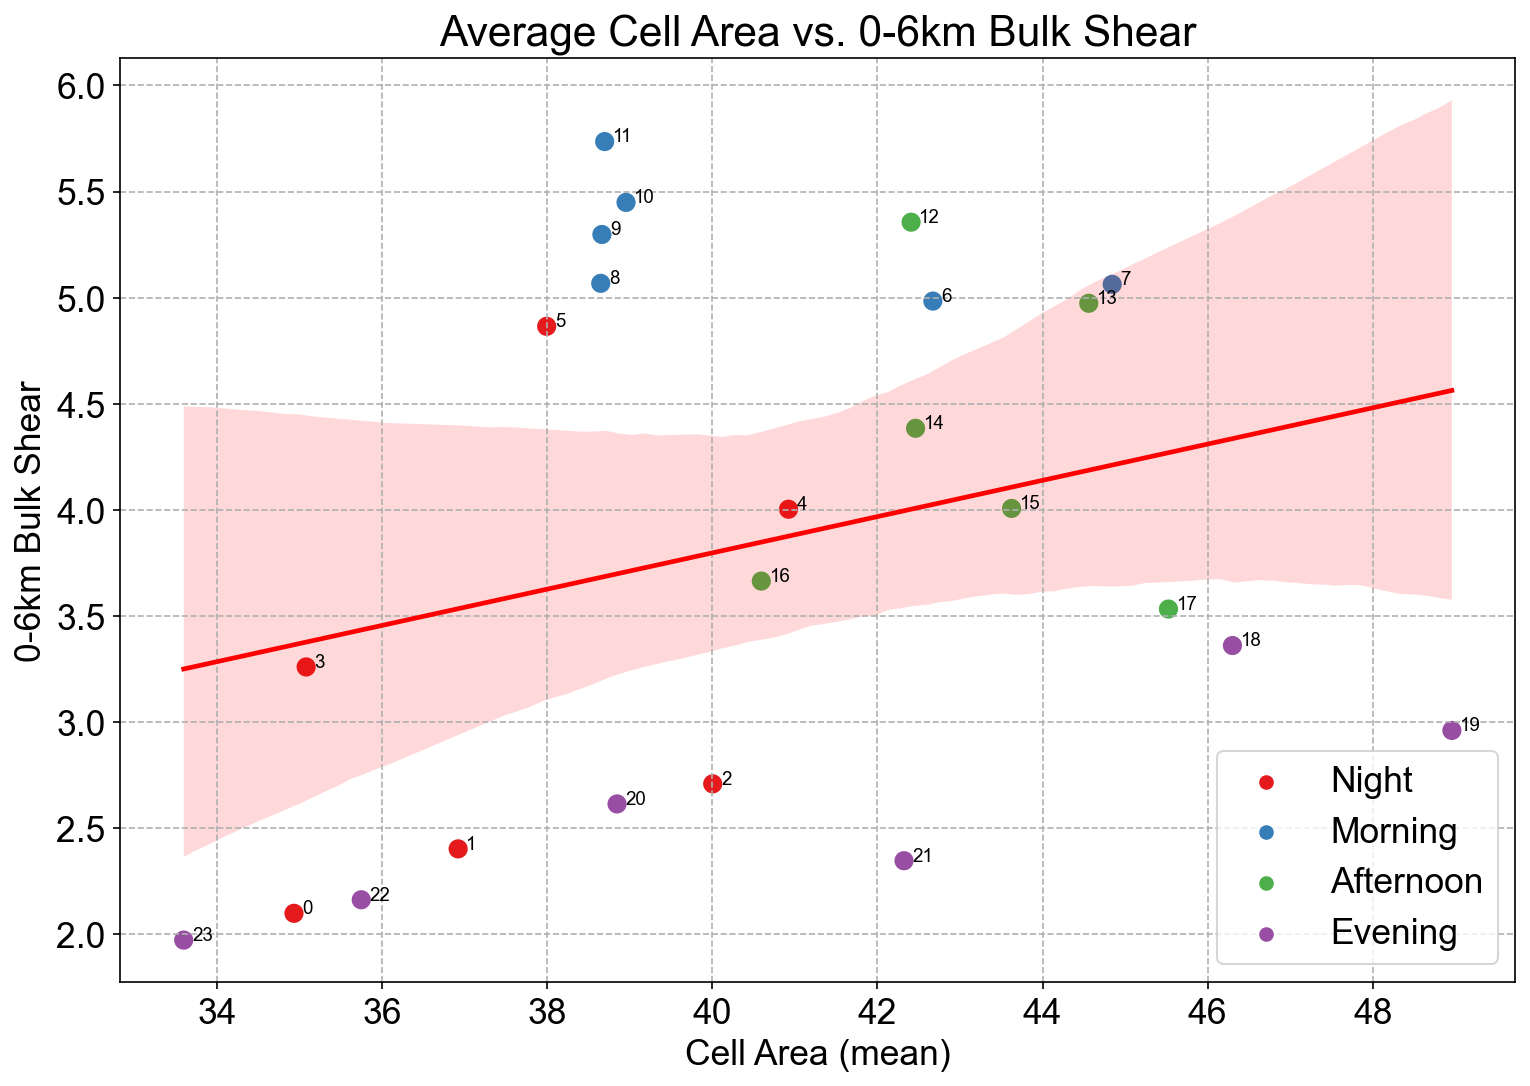

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['figure.facecolor'] = 'white'

# Load the dataset
df = result_df

# Map hours to parts of the day for color coding
def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['Hour (LT)'] = df['Hour (LT)'].astype(int)  # Ensure Hour (LT) is integer
df['Time of Day'] = df['Hour (LT)'].apply(map_time_of_day)

# Plotting
plt.figure(figsize=(12, 8), dpi=150)
sns.scatterplot(x="Cell area (mean)", y="0-6km Bulk Shear", hue="Time of Day", palette='Set1', data=df, alpha=1, markers=True, s=100)

# Adding trend line
sns.regplot(x="Cell area (mean)", y="0-6km Bulk Shear", data=df, scatter=False, line_kws={'color':'red'})

# Annotating each point with its corresponding hour, adjusting distance from the marker
x_offset = 0.1  # Adjust these values as needed to change the distance
y_offset = 0.0001  # Adjust these values as needed to change the distance
for index, row in df.iterrows():
    plt.text(row["Cell area (mean)"] + x_offset, row["0-6km Bulk Shear"] + y_offset, str(row["Hour (LT)"]), color='black', fontsize=9)


plt.title("Average Cell Area vs. 0-6km Bulk Shear")
plt.xlabel("Cell Area (mean)")
plt.ylabel("0-6km Bulk Shear")
plt.grid(ls='--')
plt.legend(loc='lower right')
plt.show()


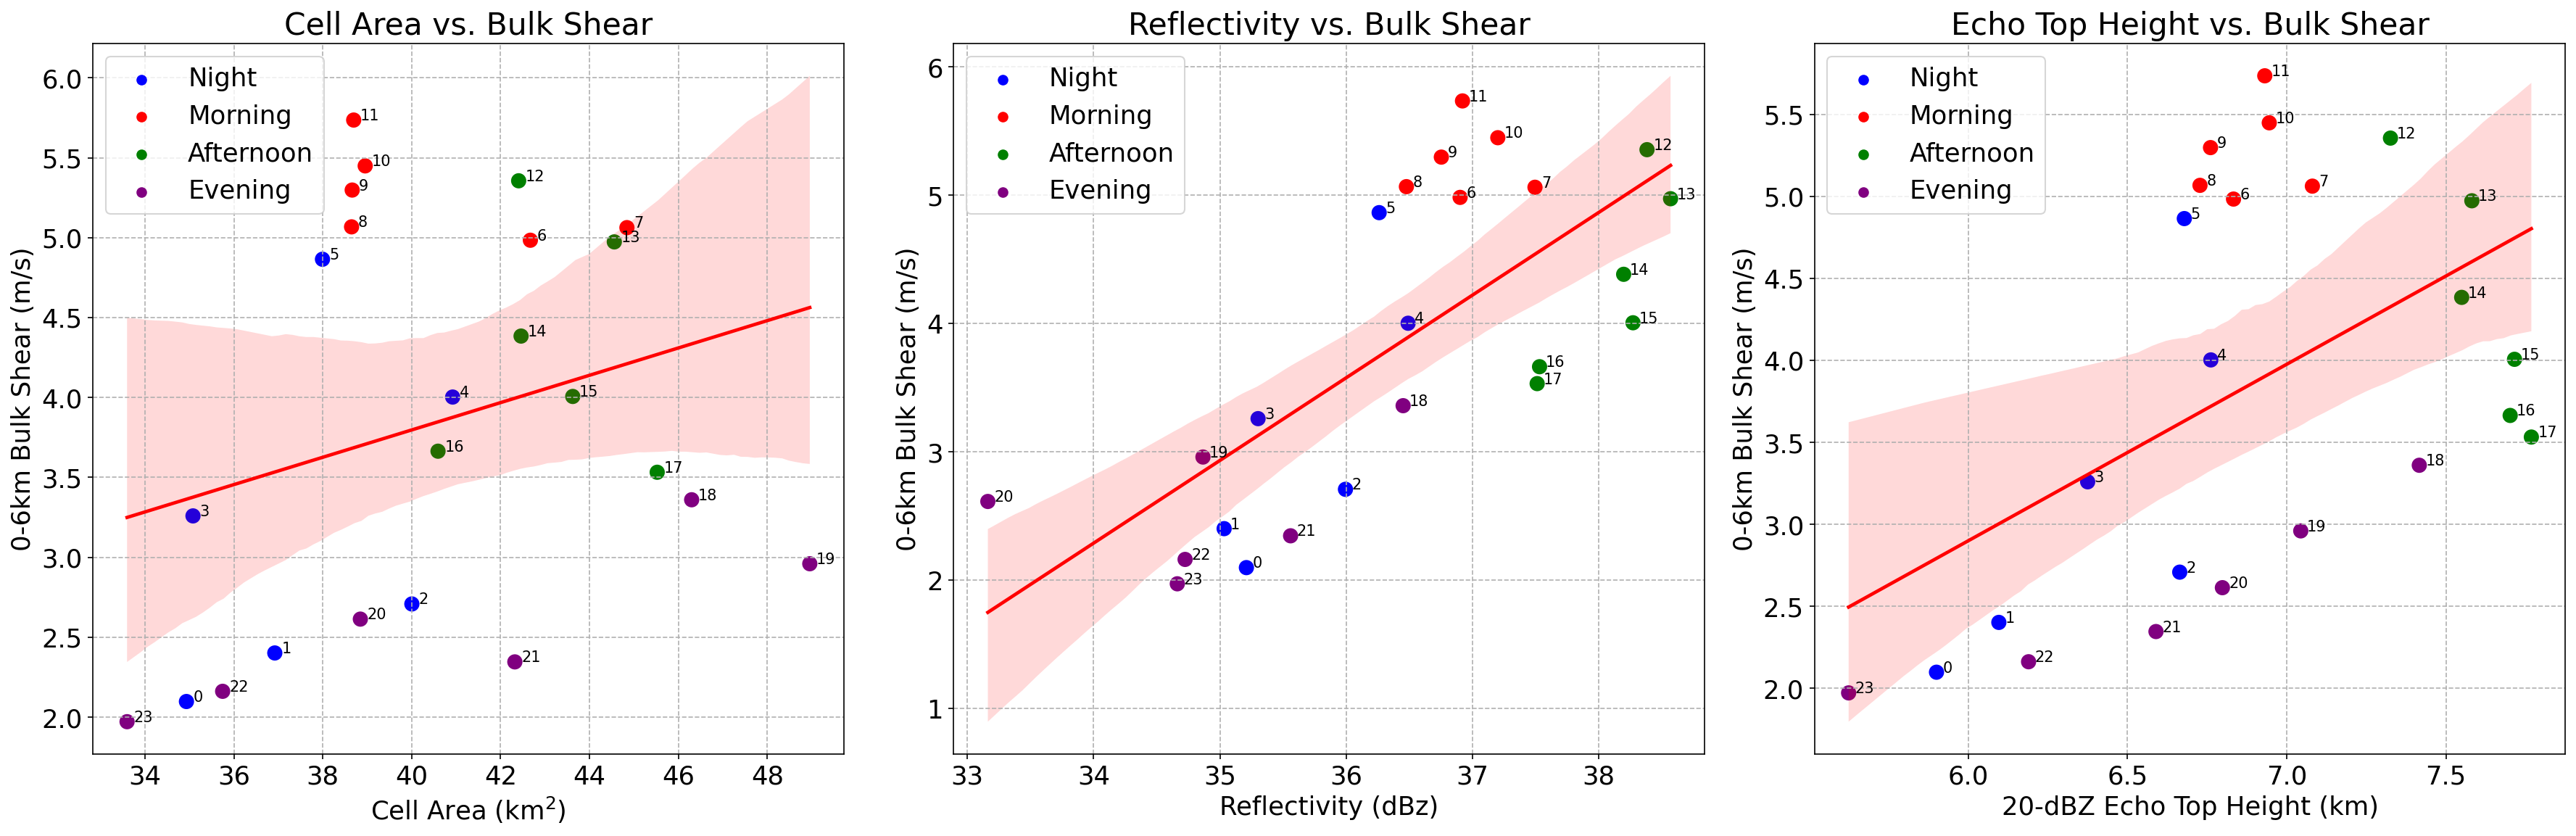

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Assuming result_df is already loaded and preprocessed as per previous steps
# Redefining the map_time_of_day function and assuming result_df structure is correct

def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Assuming 'Hour (LT)' column exists and is of integer type
result_df['Time of Day'] = result_df['Hour (LT)'].apply(map_time_of_day)

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'DejaVu Sans'  # Changed to a font that's likely to be available
mpl.rcParams['figure.facecolor'] = 'white'
palette = ['blue','red', 'green', 'purple']

# Creating 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(24, 8), dpi=150)

# Adjusting the plots to include the correct data and annotations

# Bulk Shear vs. Cell Area
sns.scatterplot(ax=axs[0], x="Cell area (mean)", y="0-6km Bulk Shear", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[0], x="Cell area (mean)", y="0-6km Bulk Shear", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Reflectivity
sns.scatterplot(ax=axs[1], x="Reflectivity (mean)", y="0-6km Bulk Shear", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[1], x="Reflectivity (mean)", y="0-6km Bulk Shear", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Echo Top Height
sns.scatterplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="0-6km Bulk Shear", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="0-6km Bulk Shear", data=result_df, scatter=False, color='red')

# Annotations and adjustments

for i, ax in enumerate(axs):
    for index, row in result_df.iterrows():
        if i == 0:  # Cell area vs. Bulk Shear
            ax.text(row["Cell area (mean)"] + 0.15, row["0-6km Bulk Shear"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        elif i == 1:  # Reflectivity vs. Bulk Shear
            ax.text(row["Reflectivity (mean)"] + 0.05, row["0-6km Bulk Shear"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        else:  # Echo Top Height vs. Bulk Shear
            ax.text(row["20-dBZ echo top height (mean)"] + 0.02, row["0-6km Bulk Shear"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)

# Titles and labels
axs[0].set_title("Cell Area vs. Bulk Shear")
axs[0].set_xlabel("Cell Area (km$^2$)")
axs[0].set_ylabel("0-6km Bulk Shear (m/s)")
axs[0].grid(ls='--')
axs[0].legend(loc='upper left')

axs[1].set_title("Reflectivity vs. Bulk Shear")
axs[1].set_xlabel("Reflectivity (dBz)")
axs[1].set_ylabel("0-6km Bulk Shear (m/s)")
axs[1].grid(ls='--')
axs[1].legend(loc='upper left')

axs[2].set_title("Echo Top Height vs. Bulk Shear")
axs[2].set_xlabel("20-dBZ Echo Top Height (km)")
axs[2].set_ylabel("0-6km Bulk Shear (m/s)")
axs[2].grid(ls='--')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()


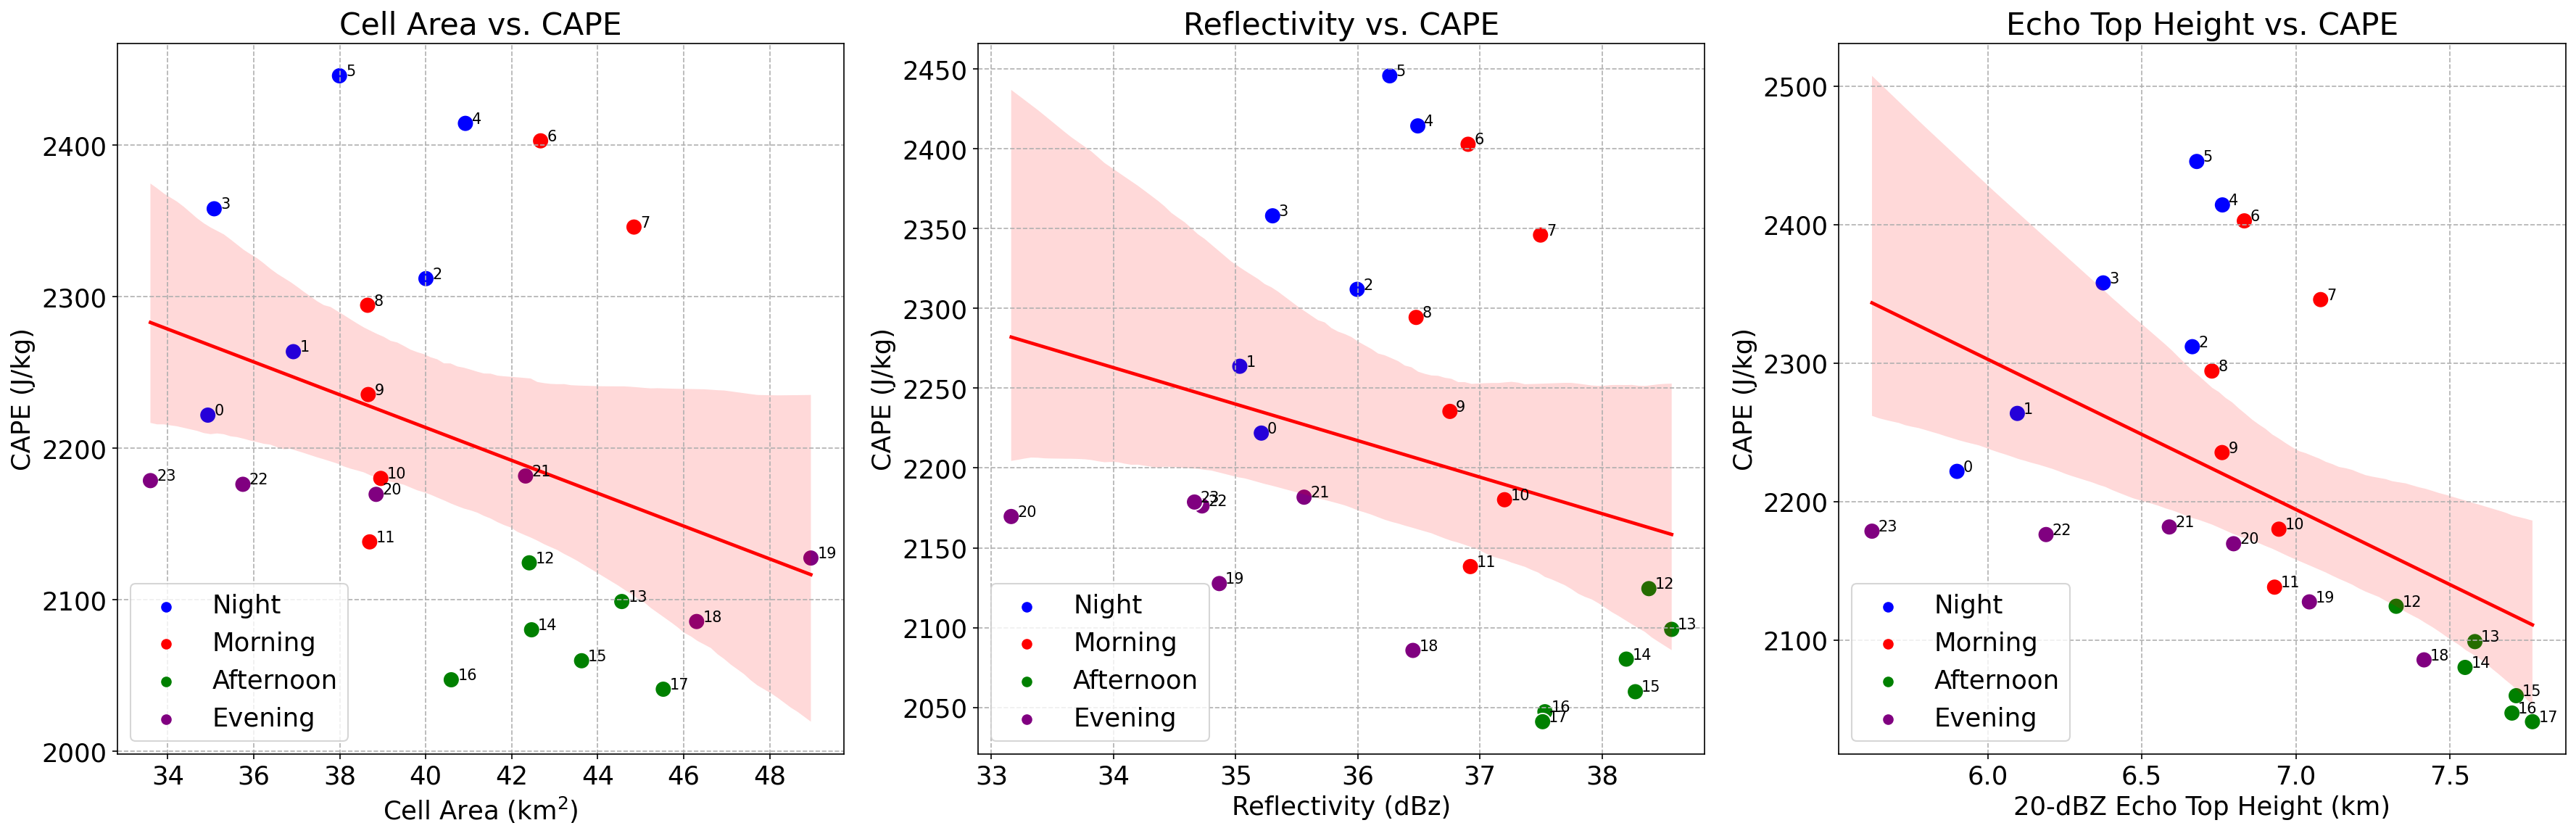

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Assuming result_df is already loaded and preprocessed as per previous steps
# Redefining the map_time_of_day function and assuming result_df structure is correct

def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Assuming 'Hour (LT)' column exists and is of integer type
result_df['Time of Day'] = result_df['Hour (LT)'].apply(map_time_of_day)

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'DejaVu Sans'  # Changed to a font that's likely to be available
mpl.rcParams['figure.facecolor'] = 'white'
palette = ['blue','red', 'green', 'purple']

# Creating 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(24, 8), dpi=150)

# Adjusting the plots to include the correct data and annotations

# Bulk Shear vs. Cell Area
sns.scatterplot(ax=axs[0], x="Cell area (mean)", y="CAPE", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[0], x="Cell area (mean)", y="CAPE", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Reflectivity
sns.scatterplot(ax=axs[1], x="Reflectivity (mean)", y="CAPE", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[1], x="Reflectivity (mean)", y="CAPE", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Echo Top Height
sns.scatterplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="CAPE", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="CAPE", data=result_df, scatter=False, color='red')

# Annotations and adjustments

for i, ax in enumerate(axs):
    for index, row in result_df.iterrows():
        if i == 0:  # Cell area vs. Bulk Shear
            ax.text(row["Cell area (mean)"] + 0.15, row["CAPE"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        elif i == 1:  # Reflectivity vs. Bulk Shear
            ax.text(row["Reflectivity (mean)"] + 0.05, row["CAPE"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        else:  # Echo Top Height vs. Bulk Shear
            ax.text(row["20-dBZ echo top height (mean)"] + 0.02, row["CAPE"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)

# Titles and labels
axs[0].set_title("Cell Area vs. CAPE")
axs[0].set_xlabel("Cell Area (km$^2$)")
axs[0].set_ylabel("CAPE (J/kg)")
axs[0].grid(ls='--')
axs[0].legend(loc='lower left')

axs[1].set_title("Reflectivity vs. CAPE")
axs[1].set_xlabel("Reflectivity (dBz)")
axs[1].set_ylabel("CAPE (J/kg)")
axs[1].grid(ls='--')
axs[1].legend(loc='lower left')

axs[2].set_title("Echo Top Height vs. CAPE")
axs[2].set_xlabel("20-dBZ Echo Top Height (km)")
axs[2].set_ylabel("CAPE (J/kg)")
axs[2].grid(ls='--')
axs[2].legend(loc='lower left')

plt.tight_layout()
plt.show()


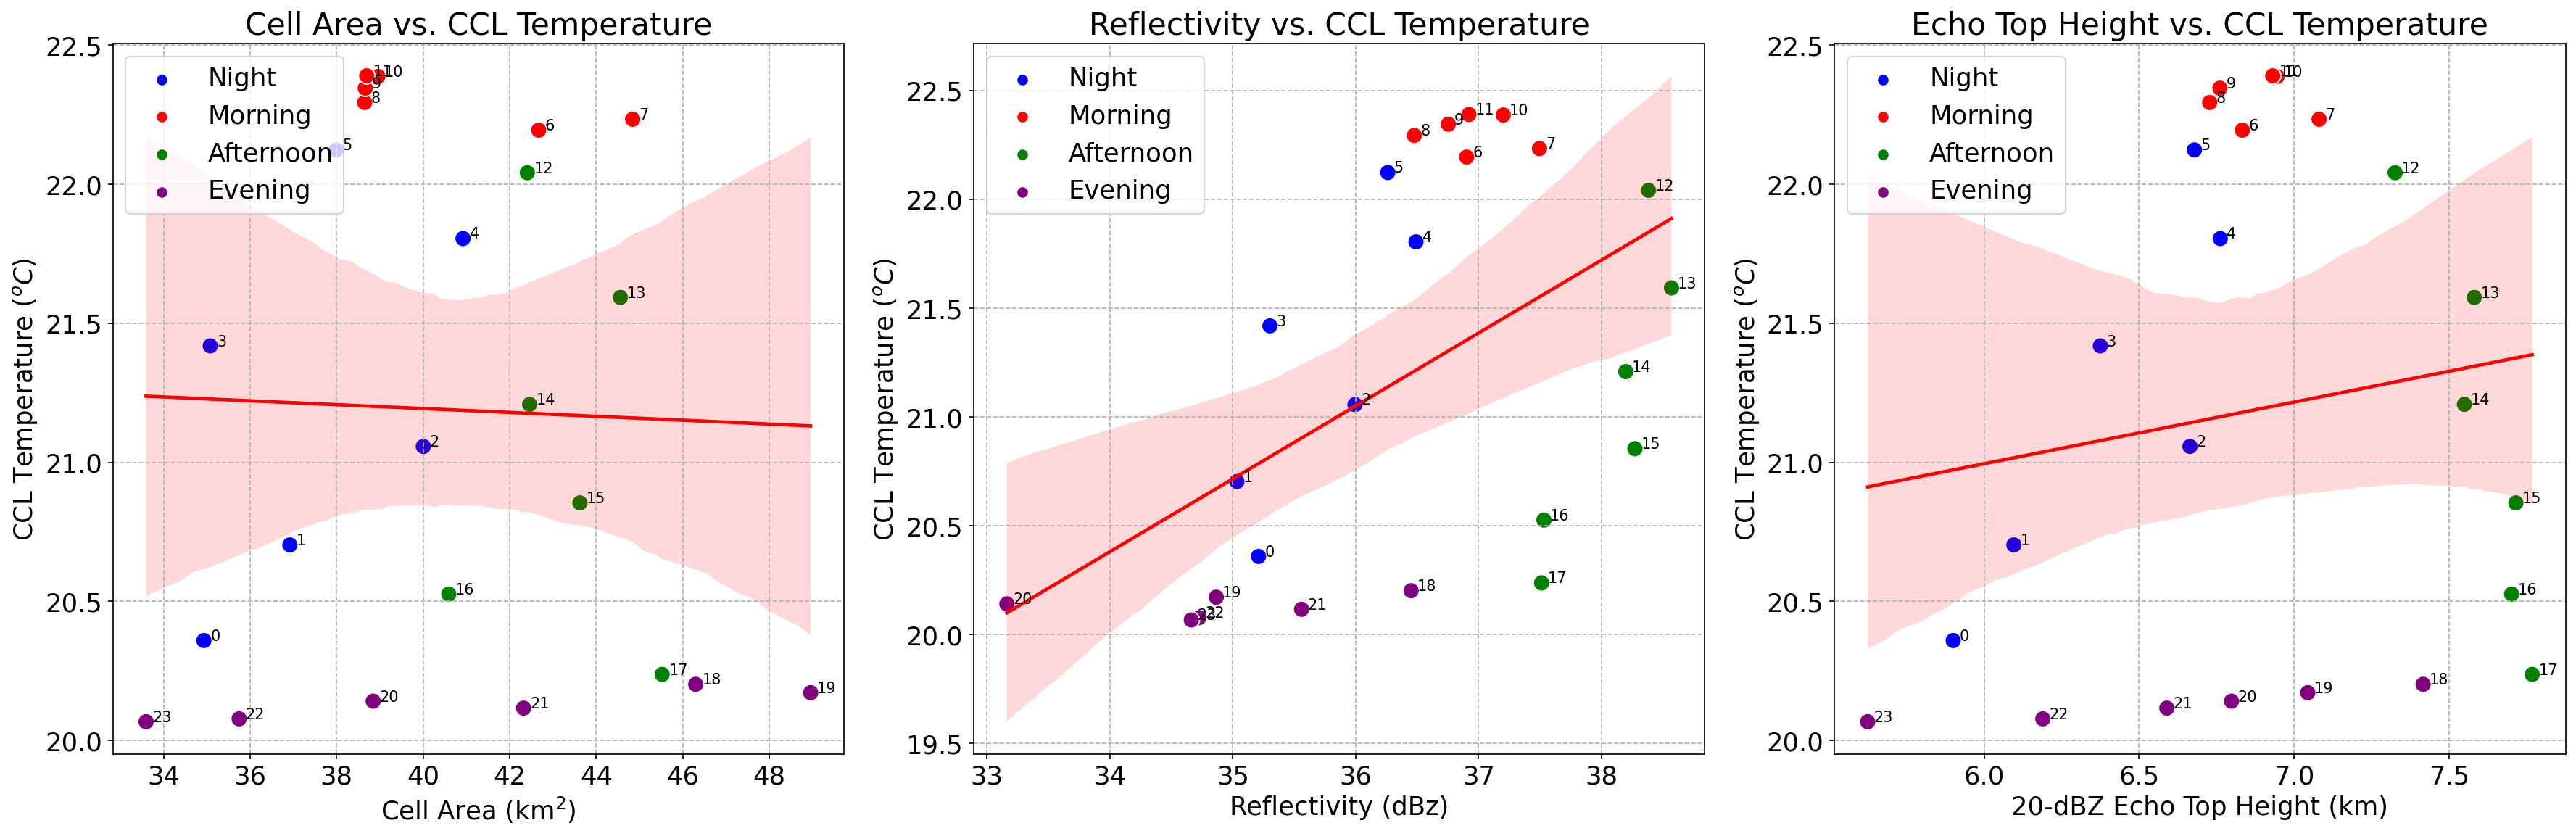

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Assuming result_df is already loaded and preprocessed as per previous steps
# Redefining the map_time_of_day function and assuming result_df structure is correct

def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Assuming 'Hour (LT)' column exists and is of integer type
result_df['Time of Day'] = result_df['Hour (LT)'].apply(map_time_of_day)

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'DejaVu Sans'  # Changed to a font that's likely to be available
mpl.rcParams['figure.facecolor'] = 'white'
palette = ['blue','red', 'green', 'purple']

# Creating 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(24, 8), dpi=150)

# Adjusting the plots to include the correct data and annotations

# Bulk Shear vs. Cell Area
sns.scatterplot(ax=axs[0], x="Cell area (mean)", y="CCL Temperature", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[0], x="Cell area (mean)", y="CCL Temperature", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Reflectivity
sns.scatterplot(ax=axs[1], x="Reflectivity (mean)", y="CCL Temperature", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[1], x="Reflectivity (mean)", y="CCL Temperature", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Echo Top Height
sns.scatterplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="CCL Temperature", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="CCL Temperature", data=result_df, scatter=False, color='red')

# Annotations and adjustments

for i, ax in enumerate(axs):
    for index, row in result_df.iterrows():
        if i == 0:  # Cell area vs. Bulk Shear
            ax.text(row["Cell area (mean)"] + 0.15, row["CCL Temperature"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        elif i == 1:  # Reflectivity vs. Bulk Shear
            ax.text(row["Reflectivity (mean)"] + 0.05, row["CCL Temperature"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        else:  # Echo Top Height vs. Bulk Shear
            ax.text(row["20-dBZ echo top height (mean)"] + 0.02, row["CCL Temperature"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)

# Titles and labels
axs[0].set_title("Cell Area vs. CCL Temperature")
axs[0].set_xlabel("Cell Area (km$^2$)")
axs[0].set_ylabel("CCL Temperature ($^oC$)")
axs[0].grid(ls='--')
axs[0].legend(loc='upper left')

axs[1].set_title("Reflectivity vs. CCL Temperature")
axs[1].set_xlabel("Reflectivity (dBz)")
axs[1].set_ylabel("CCL Temperature ($^oC$)")
axs[1].grid(ls='--')
axs[1].legend(loc='upper left')

axs[2].set_title("Echo Top Height vs. CCL Temperature")
axs[2].set_xlabel("20-dBZ Echo Top Height (km)")
axs[2].set_ylabel("CCL Temperature ($^oC$)")
axs[2].grid(ls='--')
axs[2].legend(loc='upper left')

plt.tight_layout()
plt.show()


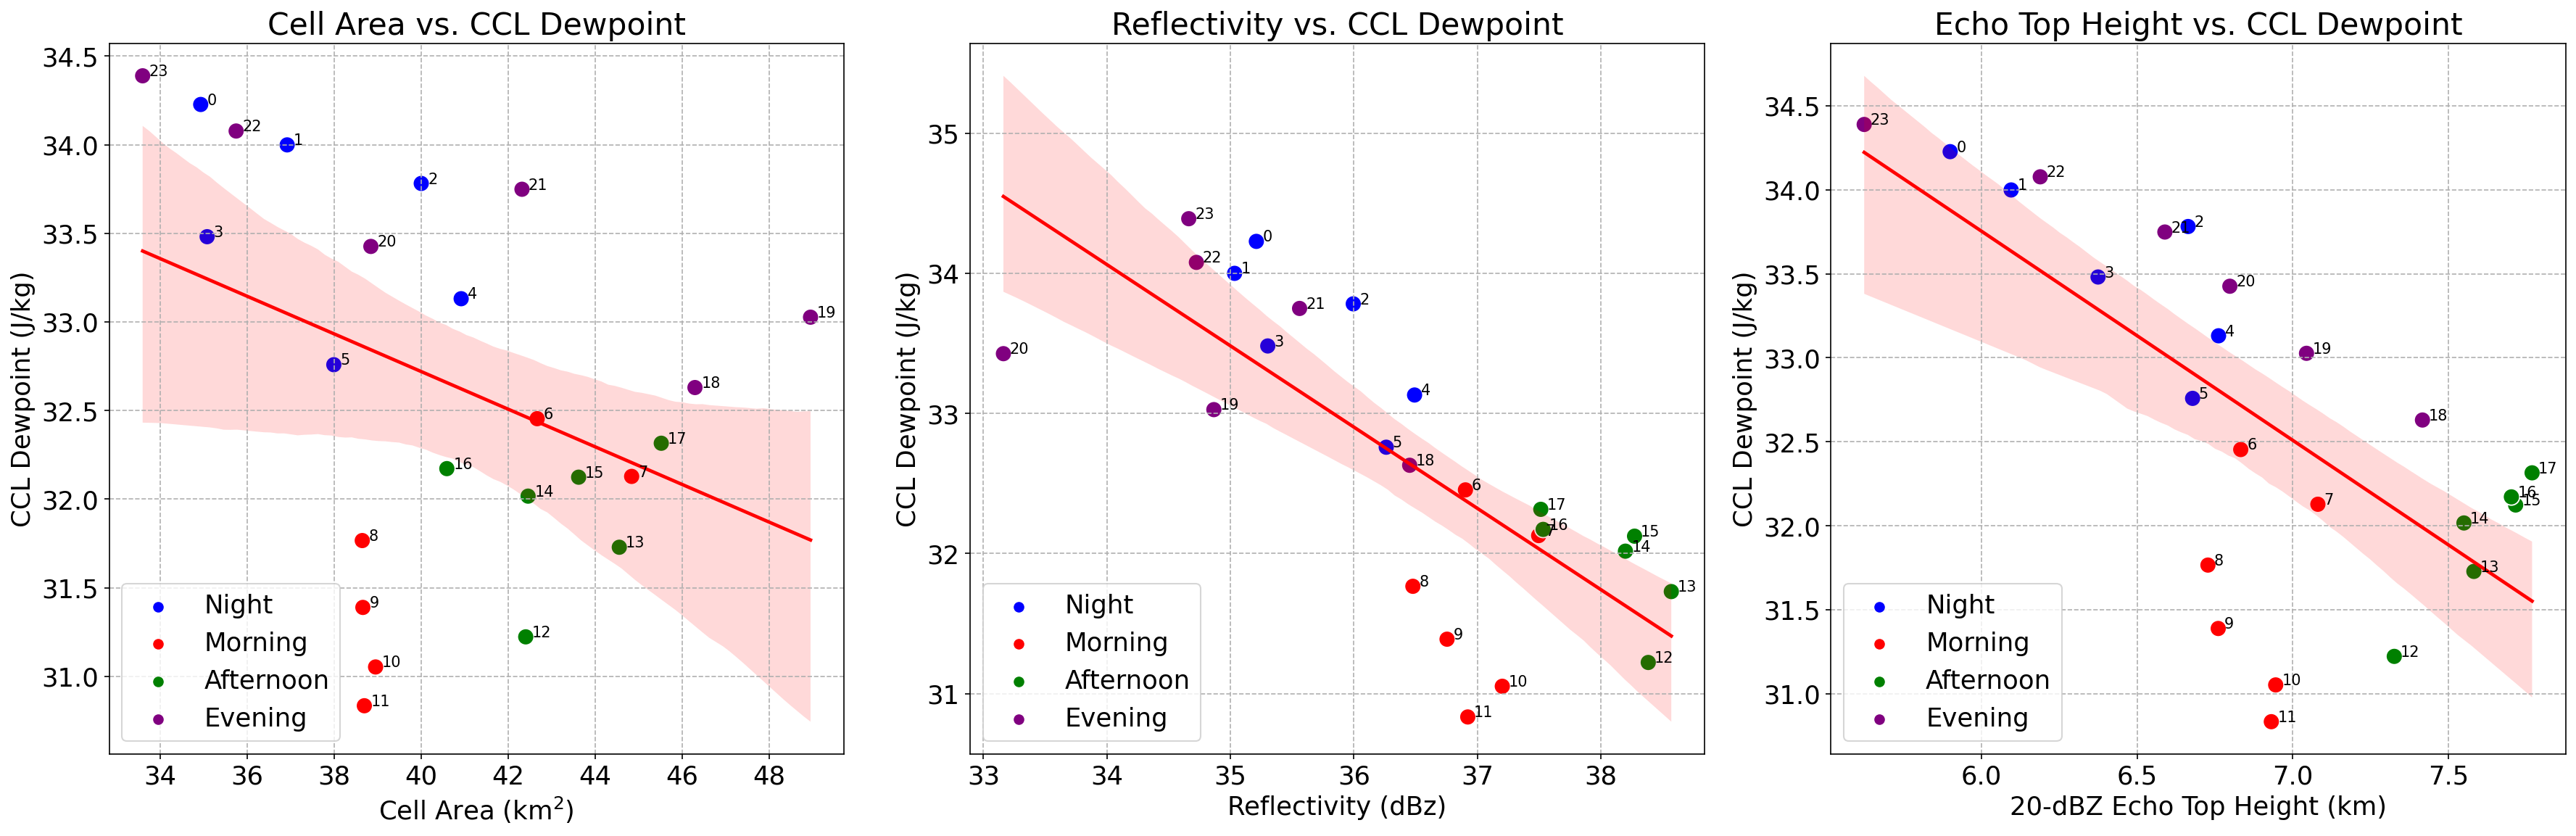

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Assuming result_df is already loaded and preprocessed as per previous steps
# Redefining the map_time_of_day function and assuming result_df structure is correct

def map_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Assuming 'Hour (LT)' column exists and is of integer type
result_df['Time of Day'] = result_df['Hour (LT)'].apply(map_time_of_day)

# Set matplotlib parameters
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'DejaVu Sans'  # Changed to a font that's likely to be available
mpl.rcParams['figure.facecolor'] = 'white'
palette = ['blue','red', 'green', 'purple']

# Creating 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(24, 8), dpi=150)

# Adjusting the plots to include the correct data and annotations

# Bulk Shear vs. Cell Area
sns.scatterplot(ax=axs[0], x="Cell area (mean)", y="CCL Dewpoint", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[0], x="Cell area (mean)", y="CCL Dewpoint", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Reflectivity
sns.scatterplot(ax=axs[1], x="Reflectivity (mean)", y="CCL Dewpoint", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[1], x="Reflectivity (mean)", y="CCL Dewpoint", data=result_df, scatter=False, color='red')

# Bulk Shear vs. Echo Top Height
sns.scatterplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="CCL Dewpoint", hue="Time of Day", palette=palette, data=result_df, alpha=1, s=120)
sns.regplot(ax=axs[2], x="20-dBZ echo top height (mean)", y="CCL Dewpoint", data=result_df, scatter=False, color='red')

# Annotations and adjustments

for i, ax in enumerate(axs):
    for index, row in result_df.iterrows():
        if i == 0:  # Cell area vs. Bulk Shear
            ax.text(row["Cell area (mean)"] + 0.15, row["CCL Dewpoint"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        elif i == 1:  # Reflectivity vs. Bulk Shear
            ax.text(row["Reflectivity (mean)"] + 0.05, row["CCL Dewpoint"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)
        else:  # Echo Top Height vs. Bulk Shear
            ax.text(row["20-dBZ echo top height (mean)"] + 0.02, row["CCL Dewpoint"] + 0, str(row["Hour (LT)"]), color='black', fontsize=10)

# Titles and labels
axs[0].set_title("Cell Area vs. CCL Dewpoint")
axs[0].set_xlabel("Cell Area (km$^2$)")
axs[0].set_ylabel("CCL Dewpoint (J/kg)")
axs[0].grid(ls='--')
axs[0].legend(loc='lower left')

axs[1].set_title("Reflectivity vs. CCL Dewpoint")
axs[1].set_xlabel("Reflectivity (dBz)")
axs[1].set_ylabel("CCL Dewpoint (J/kg)")
axs[1].grid(ls='--')
axs[1].legend(loc='lower left')

axs[2].set_title("Echo Top Height vs. CCL Dewpoint")
axs[2].set_xlabel("20-dBZ Echo Top Height (km)")
axs[2].set_ylabel("CCL Dewpoint (J/kg)")
axs[2].grid(ls='--')
axs[2].legend(loc='lower left')

plt.tight_layout()
plt.show()
